In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns




In [2]:
def get_data(data_path):
    '''returns a DataFrame with search tracks'''
    data = pd.read_json(data_path)
    data = pd.DataFrame.from_dict(data['__collections__']["search_track"])
    return data


def preprocess_data(data):
    data = data.T
    data = data.drop(columns = ['user_longitude', 'user_latitude', '__collections__'])
    data.reset_index(level=0, inplace=True)
    data.drop(columns="index")
    data['search_method'] = data['search_method'].convert_dtypes()
    
    data = data[data.search_method == 'update_time_home']
    
    data.drop(columns='index', inplace=True)
    data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True, errors='coerce')
    data['arrive'] = pd.to_datetime(data['arrive'], utc=True, errors='coerce')
    data['leave'] = pd.to_datetime(data['leave'], utc=True, errors='coerce')
    data['timestamp'] = data.timestamp.dt.strftime("%Y-%m-%d %H:%M:%S")
    data['arrive'] = data.arrive.dt.strftime("%Y-%m-%d %H:%M:%S")
    data['leave'] = data.leave.dt.strftime("%Y-%m-%d %H:%M:%S")
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['arrive'] = pd.to_datetime(data['arrive'])
    data['leave'] = pd.to_datetime(data['leave'])

    return data

def preproc(data_path):
    data = get_data(data_path)
    return preprocess_data(data)



In [3]:
data = preproc('../raw_data/dataBackup.json')
data.head(2)

,arrive,search_method,leave,search_longitude,search_latitude,uid,timestamp
7,2021-03-15 09:15:55,update_time_home,2021-03-15 09:30:55,-58.410840,-34.621459,k0hSCpQxzGZp7X1L49gDgbuYOAA2,2021-03-15 09:09:55
21,2020-09-17 10:45:00,update_time_home,2020-09-17 11:00:00,-58.451924,-34.559296,unauthenticated,2020-09-17 05:13:03


In [4]:
data["search_hour"] = data["timestamp"].dt.hour
data["arrive_hour"] = data["arrive"].dt.hour
data["leave_hour"] = data["leave"].dt.hour



In [5]:
data


,arrive,search_method,leave,search_longitude,search_latitude,uid,timestamp,search_hour,arrive_hour,leave_hour
7,2021-03-15 09:15:55,update_time_home,2021-03-15 09:30:55,-58.410840,-34.621459,k0hSCpQxzGZp7X1L49gDgbuYOAA2,2021-03-15 09:09:55,9,9,9
21,2020-09-17 10:45:00,update_time_home,2020-09-17 11:00:00,-58.451924,-34.559296,unauthenticated,2020-09-17 05:13:03,5,10,11
62,2020-09-22 11:30:00,update_time_home,2020-09-22 11:45:00,-58.991541,-34.418388,unauthenticated,2020-09-22 10:08:28,10,11,11
102,2020-09-21 03:00:00,update_time_home,2020-09-21 03:15:00,-58.429728,-34.602570,unauthenticated,2020-09-20 18:13:27,18,3,3
111,2021-01-23 17:30:24,update_time_home,2021-01-23 18:15:22,-58.425242,-34.593539,wiQNlKI9LNfTGgmoElxxMTiyl6Q2,2021-01-23 17:17:24,17,17,18
...,...,...,...,...,...,...,...,...,...,...
19801,2021-02-16 15:00:52,update_time_home,2021-02-16 15:15:52,-58.478772,-34.551283,CKMmhmI2ZOdD7kZHudefzuAOxLY2,2021-02-16 14:47:04,14,15,15
19815,2021-02-01 03:30:41,update_time_home,2021-02-01 04:30:41,-58.395646,-34.605682,unauthenticated,2021-02-01 03:20:20,3,3,4
19818,2021-03-10 11:45:00,update_time_home,2021-03-10 12:45:18,-58.562289,-34.643518,unauthenticated,2021-03-10 11:39:00,11,11,12
19832,2020-12-03 10:45:55,update_time_home,2021-01-03 10:30:00,-58.381810,-34.617379,unauthenticated,2020-12-03 10:43:32,10,10,10


In [6]:

data['stay_time'] = (data["leave_hour"] - data['arrive_hour']).astype('timedelta64[h]')
data["arrive_weekday"] = data["arrive"].dt.weekday
data.head(2)

,arrive,search_method,leave,search_longitude,search_latitude,uid,timestamp,search_hour,arrive_hour,leave_hour,stay_time,arrive_weekday
7,2021-03-15 09:15:55,update_time_home,2021-03-15 09:30:55,-58.410840,-34.621459,k0hSCpQxzGZp7X1L49gDgbuYOAA2,2021-03-15 09:09:55,9,9,9,0 days 00:00:00,0
21,2020-09-17 10:45:00,update_time_home,2020-09-17 11:00:00,-58.451924,-34.559296,unauthenticated,2020-09-17 05:13:03,5,10,11,0 days 01:00:00,3


In [7]:
def search_neighborhood(neighborhood, coordinates):

    bsas_map = gpd.read_file('../gopa_data/barrios-ciudad')
    neighborhood = neighborhood.upper()
    gpd_data = gpd.GeoDataFrame(coordinates,
                         geometry = gpd.points_from_xy(coordinates.search_longitude, coordinates.search_latitude))
    reservas_bsas = gpd_data[['geometry']]
    reservas_bsas = reservas_bsas.set_crs("EPSG:4326")

    if neighborhood == 'CIUDAD':
        df_barrio = bsas_map
        fig,ax = plt.subplots(figsize = (15,16))
        bsas_map.plot(ax=ax, color='lightgrey')
        gpd_data.plot(ax=ax, markersize=5, color='red')
        ax.set_xlim([-58.550, -58.325])
        ax.set_ylim([-34.700, -34.525])
        plt.show()

    else:

        try:
            df_barrio = bsas_map[bsas_map['BARRIO'] == neighborhood]
            reservas_barrio = reservas_bsas.within(df_barrio)
            cond_reservas_barrio = gpd_data.apply(lambda x: df_barrio.contains(x.geometry), axis=1)
            gpd_data['reservas_barrio'] = cond_reservas_barrio
            gpd_data = gpd_data[gpd_data.reservas_barrio == True]
            fig,ax = plt.subplots(figsize = (15,16))
            bsas_map.plot(ax=ax, color='lightgrey')
            gpd_data.plot(ax=ax, markersize=5, color='red')
            ax.set_xlim([-58.550, -58.325])
            ax.set_ylim([-34.700, -34.525])
            plt.show()
        except ValueError:
            print("Please enter another neighborhood")


    return gpd_data

/Users/santiagolazzari/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/geopandas/base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


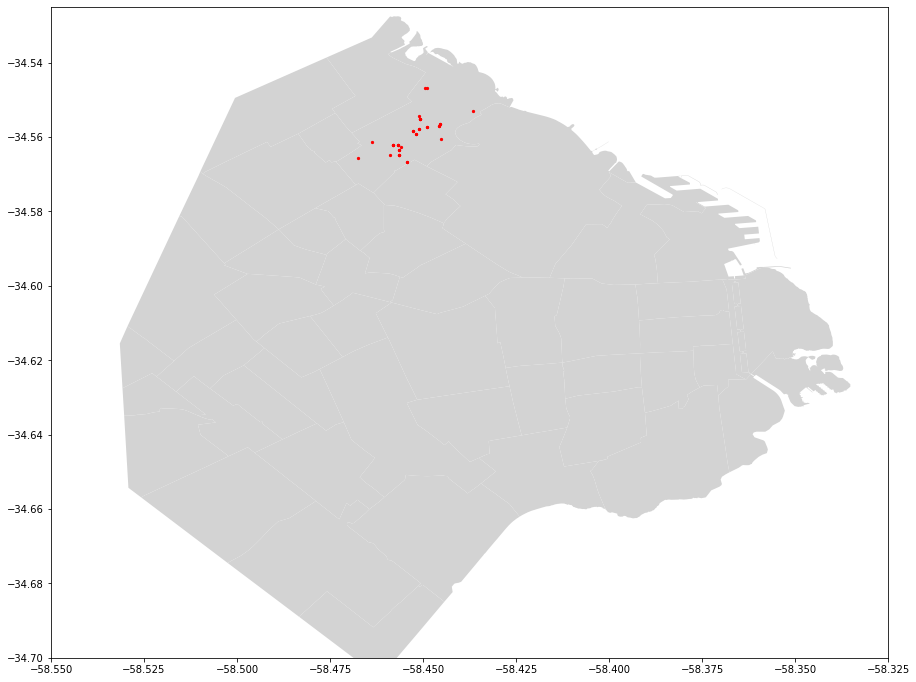

In [8]:
belgrano = search_neighborhood(neighborhood = 'belgrano', coordinates=data)

/Users/santiagolazzari/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/geopandas/base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


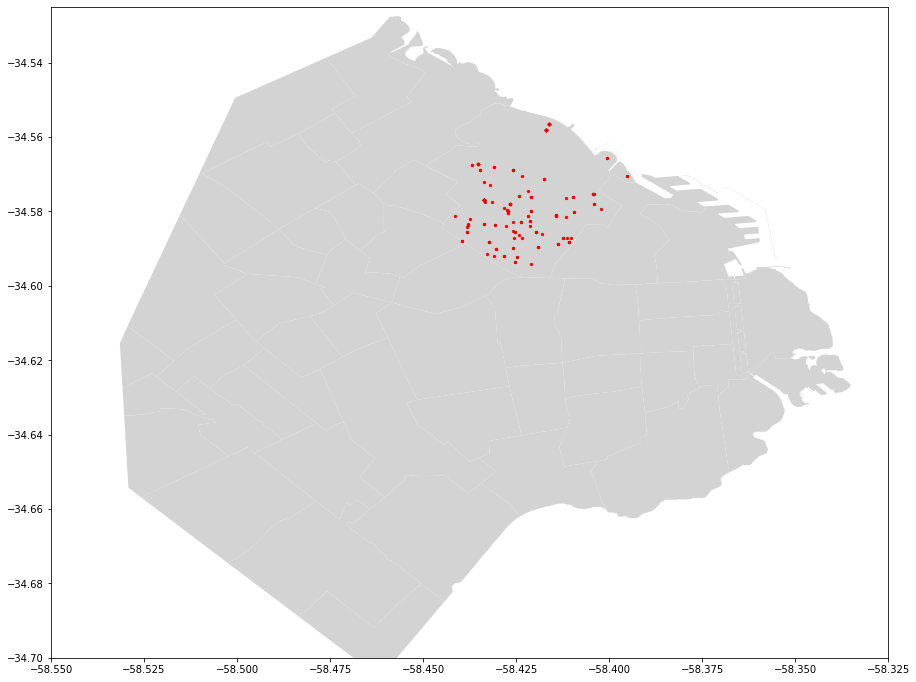

In [9]:
palermo = search_neighborhood(neighborhood = 'caba', coordinates=data)

/Users/santiagolazzari/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/geopandas/base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


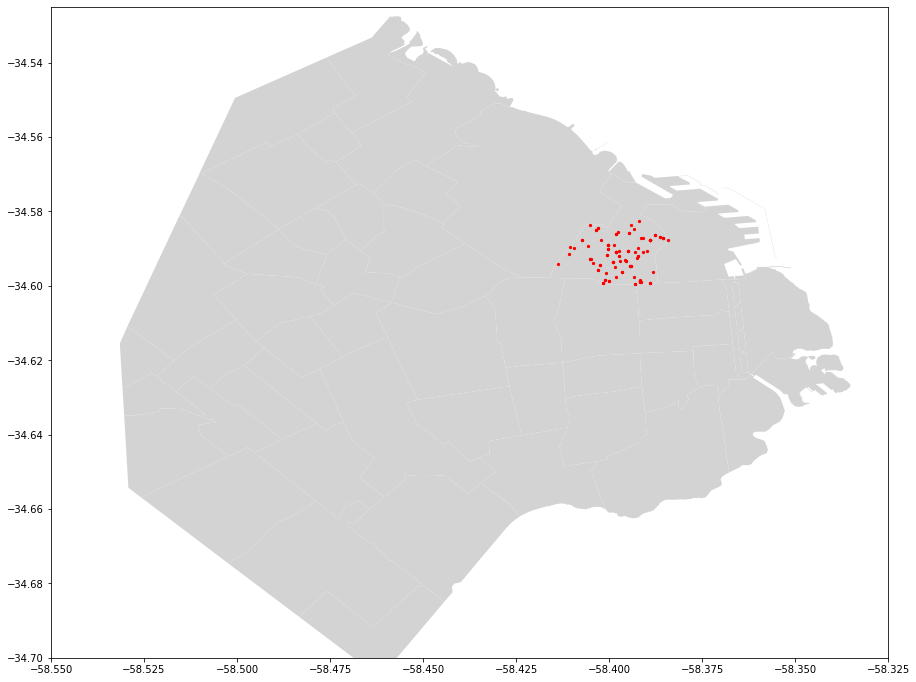

In [10]:
recoleta = search_neighborhood(neighborhood = 'recoleta', coordinates=data)

<AxesSubplot:xlabel='search_hour', ylabel='Count'>

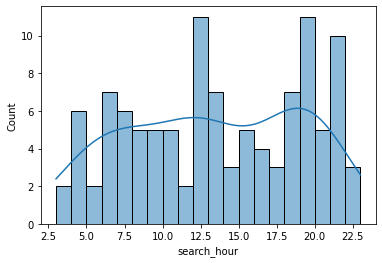

In [11]:
sns.histplot(data=recoleta, x="search_hour", binwidth=1, kde=True)



<AxesSubplot:xlabel='search_hour', ylabel='Count'>

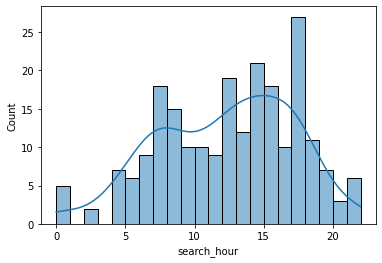

In [12]:
sns.histplot(data=palermo, x="search_hour", binwidth=1, kde=True)


<AxesSubplot:xlabel='search_hour', ylabel='Count'>

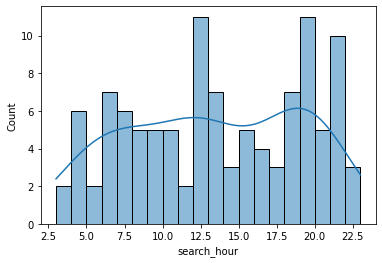

In [13]:
sns.histplot(data=recoleta, x="search_hour", binwidth=1, kde=True)


<AxesSubplot:xlabel='arrive_hour', ylabel='Count'>

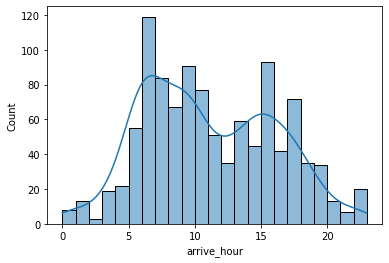

In [14]:
sns.histplot(data=data, x="arrive_hour", binwidth=1, kde=True)


<AxesSubplot:xlabel='arrive_weekday', ylabel='Count'>

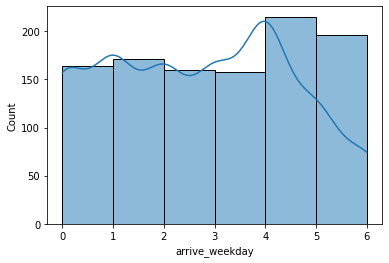

In [15]:
sns.histplot(data=data, x="arrive_weekday", binwidth=1, kde=True)


<AxesSubplot:xlabel='arrive_hour', ylabel='Count'>

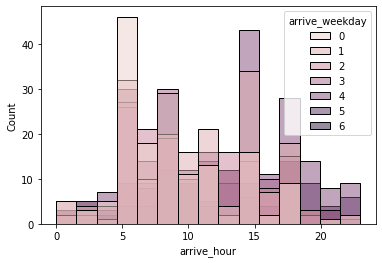

In [16]:
sns.histplot(data=data, x="arrive_hour", hue="arrive_weekday")


<AxesSubplot:xlabel='arrive_hour', ylabel='arrive_weekday'>

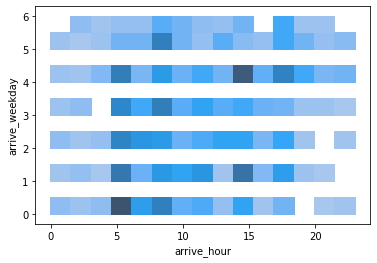

In [17]:
sns.histplot(data=data, x="arrive_hour", y="arrive_weekday", legend=True)

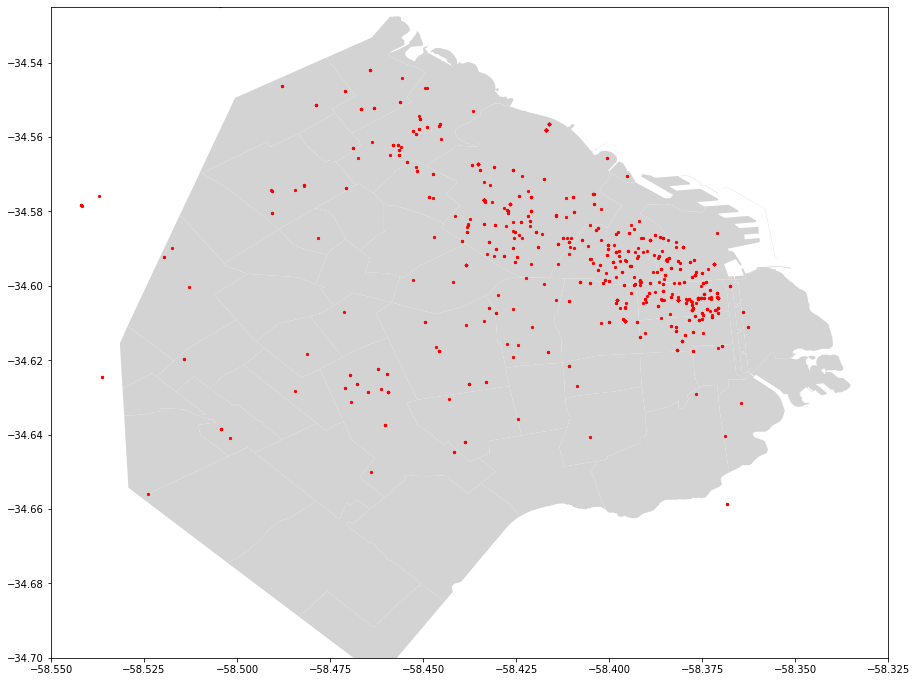

TypeError: invalid type promotion

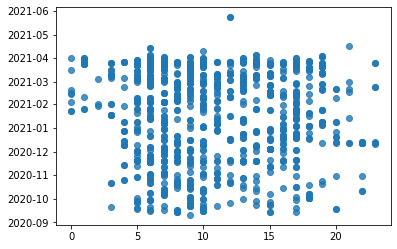

In [21]:
caba = search_neighborhood(neighborhood = 'ciudad', coordinates=data)
ax = sns.regplot(x="arrive_hour", y="arrive", data=caba)